#### Задание:

С использованием библиотек Numpy и Pandas написать программу реализующую:

1. Загрузку текстового файла из корневого каталога объемом не менее 20000 символов включая пробелы и все символы.
2. Подсчет частоты встречаемости слов в загруженном файле (критерий схожести слов выбрать самостоятельно).
3. Подсчет длин предложений и их количества.
4. Ввод полученных данных в объект DataFrame и Series, а также отображение полученных результатов в виде таблицы "объекты - признаки".
5. Построение гистограммы частоты встречаемости слов.

p.s. Рекомендую перед решением задания проанализировать задачу и обосновать алгоритм ее решения в текстовом виде. В процессе написания кода использовать комментарии.

In [190]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [191]:
def collect_data_from_file(file_name):
    total_number_of_sentences = 0 # кол-во предложений в тексте
    total_number_of_words = 0 # кол-во слов в тексте
    lengths_of_sentences = [] # список длин каждого предложения
    storage_of_words = [] # список всех слов, после список уникальных слов
    
    with open(file_name, "rt") as file:
        for line in file.readlines():
            sentences = list(filter(None, re.split("[.!?\n]+", line))) # список предложений в пределах одного абзаца
            total_number_of_sentences += len(sentences)

            for sentence in sentences:
                if sentence[0] == " ": # подсчет длин предложений
                    lengths_of_sentences.append(len(sentence))
                else:
                    lengths_of_sentences.append(len(sentence) + 1)

                sentence = sentence.lower()
                words = list(filter(None, re.split("[“(/ ,;:–)”]+", sentence))) # список слов в пределах одного предложения
                                        
                for word in words: # наполнение списка слов
                    storage_of_words.append(word)
                total_number_of_words += len(words)    
                
    return (total_number_of_words, total_number_of_sentences, lengths_of_sentences, storage_of_words)


def sentence_dataframe(lengths_of_sentences):
    # Формирование DataFrame с длинами предложений
    sentence_length_series = pd.Series(lengths_of_sentences,
                   index = range(1, len(lengths_of_sentences)+1))
    sentence_df = pd.DataFrame(
                {"Длина_предложения": sentence_length_series})
    
    return sentence_df


def words_dataframes(storage_of_words, total_number_of_words):
    counter_of_words = [] # список кол-ва вхождений слова в текст
    storage_of_words.sort()

    for word in storage_of_words: # преобразование списка всех слов в список уникальных слов
        counter_of_words.append(storage_of_words.count(word))
        for i in range(storage_of_words.count(word) - 1):
            storage_of_words.remove(word)
            
    # Разделение слов на сегменты по степени сходства и посдсчет кол-ва слов в каждом сегменте
    classes_of_words, counter_of_classes_of_words = segregator(storage_of_words, counter_of_words)
    
    # Формирование DataFrame с похожими словами
    counter_of_classes_of_words_series = pd.Series(classes_of_words,
                                                    index = counter_of_classes_of_words)
    segregated_words_df = pd.DataFrame(
                            {"Похожие слова": counter_of_classes_of_words_series})
    frequency_of_segregated_words_series = segregated_words_df.index / total_number_of_words
    segregated_words_df["Частота"] = frequency_of_segregated_words_series  
    
    # Формирование DataFrame с уникальными словами
    counter_of_words_series = pd.Series(counter_of_words,
                                        index = storage_of_words)
    words_df = pd.DataFrame(
                {"Количество": counter_of_words_series})
    frequency_of_words_series = words_df.Количество / total_number_of_words
    words_df["Частота"] = frequency_of_words_series 
    
    return (words_df, segregated_words_df, classes_of_words)


def print_frequency_hist(df):
    x = range(len(df.Частота))
    ax = plt.gca()
    ax.bar(x, df.Частота)
    plt.show()
    
    
def levenshtein_distance(a, b):
    n, m = len(a), len(b)
    if n > m:
        a, b = b, a
        n, m = m, n

    current_row = range(n+1) # Keep current and previous row, not entire matrix
    for i in range(1, m+1):
        previous_row, current_row = current_row, [i]+[0]*n
        for j in range(1,n+1):
            add, delete, change = previous_row[j]+1, current_row[j-1]+1, previous_row[j-1]
            if a[j-1] != b[i-1]:
                change += 1
            current_row[j] = min(add, delete, change)
            
    return current_row[n]


def segregator(storage_of_words, counter_of_words):
    classes_of_words = [] # список сегментов похожих слов
    counter_of_classes_of_words = [] # список кол-ва вхождений похожих в текст по сегментами
    i = 0
    k = 0
    
    while i <= (len(storage_of_words)-1):
        j = 1
        classes_of_words.append([storage_of_words[i]])
        counter_of_classes_of_words.append(counter_of_words[i])
        
        while i+j < len(storage_of_words):
            max_word_len = max(len(storage_of_words[i]), len(storage_of_words[i+j]))
            distance = levenshtein_distance(storage_of_words[i], storage_of_words[i+j])
            border = distance / max_word_len # метрика: отношение (расстояния Левенштейна между двумя словами)
                                             # к длине наибольшего слова
            
            if border < 0.34: # 0.34 - пороговое значение принятия слова за "похожее"
                classes_of_words[k].append(storage_of_words[i+j])
                counter_of_classes_of_words[k] += counter_of_words[i+j]
                j += 1
            else:
                break

        i += j
        k += 1
        
    return (classes_of_words, counter_of_classes_of_words)

In [192]:
file_name = "data.txt"
total_number_of_words, total_number_of_sentences, lengths_of_sentences, storage_of_words = collect_data_from_file(file_name)
sentence_df = sentence_dataframe(lengths_of_sentences)
words_df, segregated_words_df, classes_of_words = words_dataframes(storage_of_words, total_number_of_words)

print("Количество слов =", total_number_of_words)
print("Количество предложений =", total_number_of_sentences)
print("Количество уникальных слов =", len(storage_of_words))
print("Количество похожих слов =", len(classes_of_words))

Количество слов = 3841
Количество предложений = 169
Количество уникальных слов = 975
Количество похожих слов = 796


In [193]:
print("Таблица длин предложений:\n")
pd.set_option('display.max_rows', None)
print(sentence_df)

Таблица длин предложений:

     Длина_предложения
1                   98
2                  148
3                  120
4                   75
5                   89
6                   66
7                   35
8                    2
9                  139
10                  58
11                  56
12                  72
13                  27
14                  28
15                  23
16                 142
17                 129
18                  43
19                 198
20                 106
21                 101
22                 188
23                 152
24                 190
25                 171
26                 169
27                 172
28                 139
29                 149
30                  96
31                 184
32                 160
33                 160
34                 122
35                 113
36                 187
37                  86
38                 107
39                 220
40                  87
41                 114
42     

In [194]:
print("Таблица количества и частот уникальных слов:\n")
pd.set_option('display.max_rows', None)
print(words_df)

Таблица количества и частот уникальных слов:

                  Количество   Частота
1                          1  0.000260
10000                      1  0.000260
1514                       1  0.000260
1609                       1  0.000260
1687                       1  0.000260
1691                       1  0.000260
1781                       1  0.000260
1823                       1  0.000260
200                        1  0.000260
340                        1  0.000260
400000                     1  0.000260
5000                       1  0.000260
a                         98  0.025514
abandon                    1  0.000260
ability                    1  0.000260
able                       1  0.000260
about                     14  0.003645
above                      3  0.000781
absorbing                  1  0.000260
absorption                 1  0.000260
absurd                     1  0.000260
accepted                   4  0.001041
accident                   1  0.000260
accompanied       

Гистограмма частот встречаемости уникальных слов:


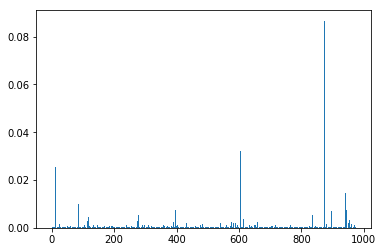

In [195]:
print("Гистограмма частот встречаемости уникальных слов:")
print_frequency_hist(words_df)

In [197]:
print("Таблица количества и частот похожих слов:\n")
pd.set_option('display.max_rows', None)
print(segregated_words_df)

Таблица количества и частот похожих слов:

                                  Похожие слова   Частота
1                                           [1]  0.000260
1                                       [10000]  0.000260
1                                        [1514]  0.000260
1                                        [1609]  0.000260
1                                        [1687]  0.000260
1                                        [1691]  0.000260
1                                        [1781]  0.000260
1                                        [1823]  0.000260
1                                         [200]  0.000260
1                                         [340]  0.000260
1                                      [400000]  0.000260
1                                        [5000]  0.000260
98                                          [a]  0.025514
1                                     [abandon]  0.000260
1                                     [ability]  0.000260
1                            